# Plant Seedling Classification

In [2]:
import numpy as np
import pandas as pd

# tqdm provides responsive progress bars for notebooks.
from tqdm import tqdm_notebook

# For displaying sample images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

# preprocessing
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing import image

# CNN construction
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Transfer Learning
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

# Model Training
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint

# For filesystem operations in saving augmented data to disk
import shutil
import os
import random

# For Model Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import itertools 

# For Prediction
from glob import glob



In [3]:
data = load_files('train', load_content=False, shuffle=True, random_state=42)

### Display images 

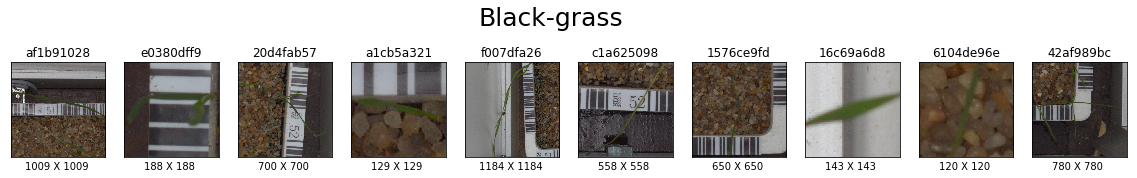

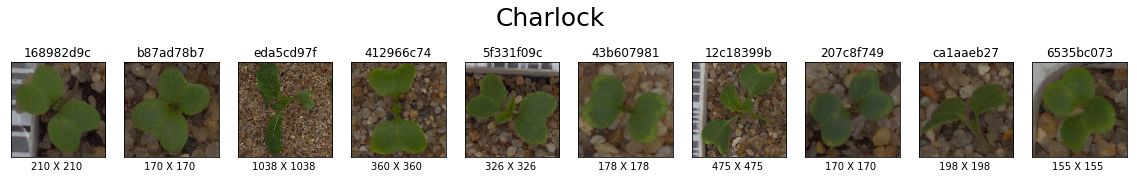

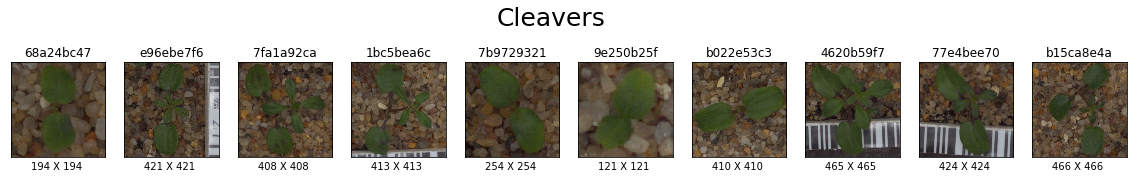

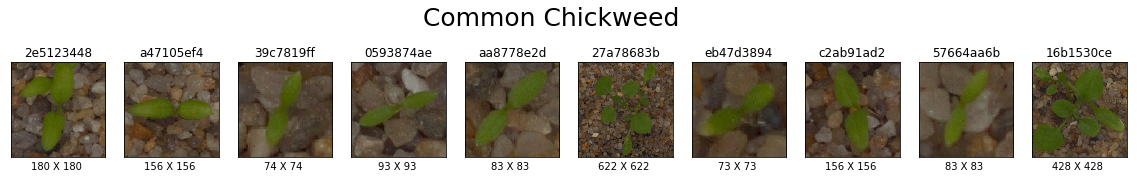

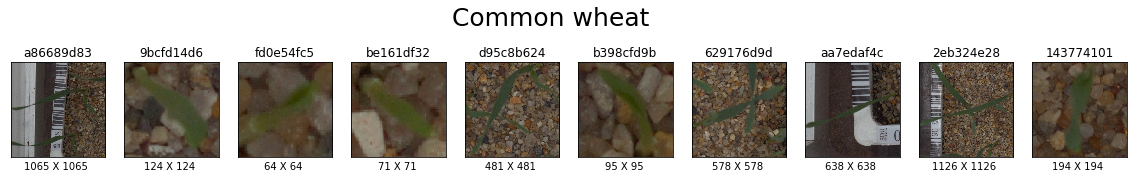

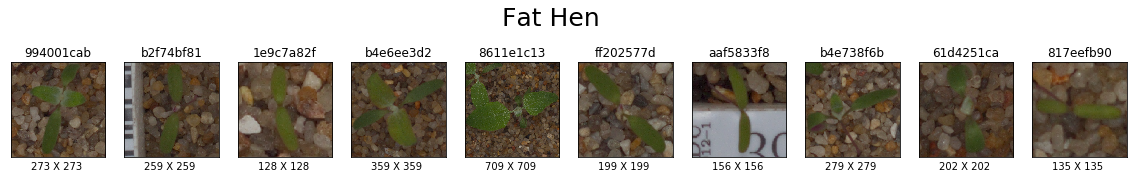

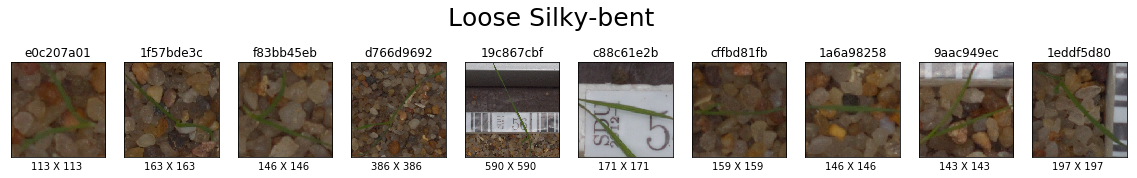

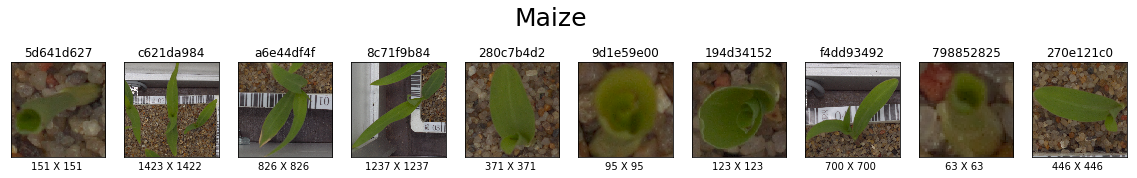

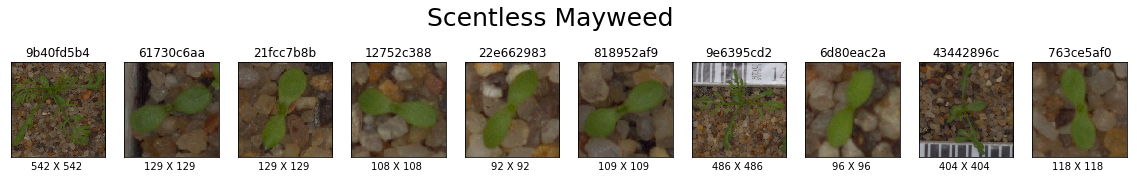

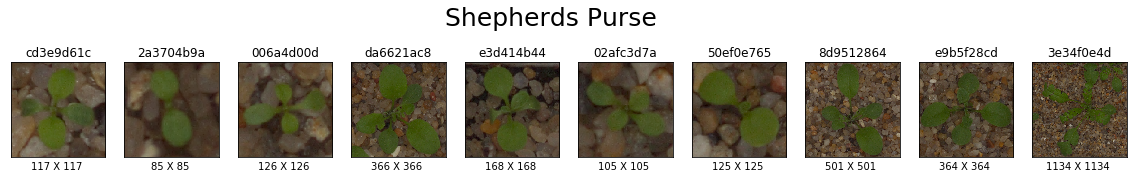

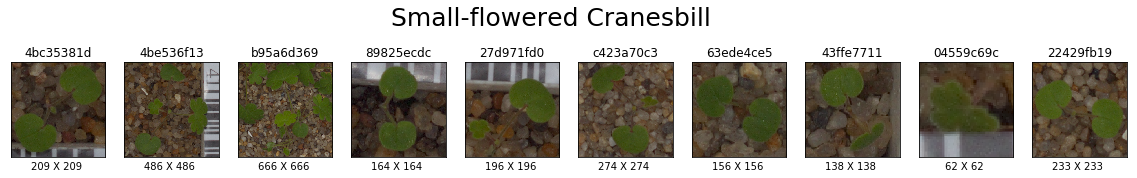

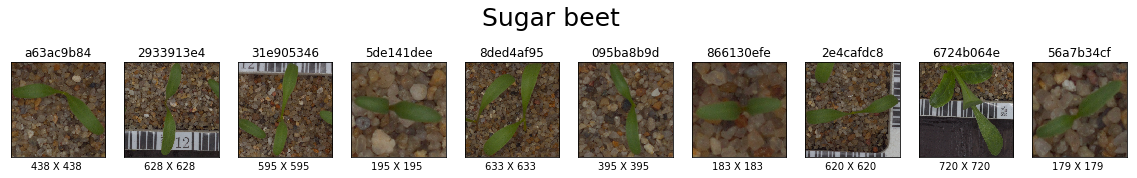

In [4]:
"""
Display 10 samples for each class
Each image's title is its filename. Each image's subtitle is it's height and width in pixels.
"""
def display_image_samples(n=10):
    for seedling_id in range(12):
        figure = plt.figure(figsize=(20,3))
        figure.suptitle(data['target_names'][seedling_id], fontsize=25)
        imgs = [i for i, j in enumerate(data['target']) if j == seedling_id]
        for i in range(n):
            seedling_file = data['filenames'][imgs[i]]
            with Image.open(seedling_file) as img:
                width, height = img.size
                ax = figure.add_subplot(1, n, i+1, xticks=[], yticks=[])
                ax.imshow(mpimg.imread(seedling_file))
                ax.set_title(seedling_file[-13:-4])
                ax.set_xlabel("%d X %d " % (width, height))
        plt.show()

display_image_samples()

### Count dataset

In [7]:
def load_dataset(path):
    data         = load_files(path)
    plant_files  = np.array(data['filenames'])
    plant_targets= np_utils.to_categorical(np.array(data['target']),12)
    return plant_files,plant_targets

print('Loading Train Files and Targets')
train_files, train_targets = load_dataset('train')
print('Loading Complete!')
print('There are %d training plant images.' % len(train_files))

Loading Train Files and Targets
Loading Complete!
There are 4750 training plant images.


In [14]:
# list of plant categories
plant_names = [item[58:-1] for item in sorted(glob("train/*/"))]
print('There are %d total plant categories.' % len(plant_names))


There are 12 total plant categories.


### Split Train Test Data

In [5]:
"""
Splits data into training and testing sets.
"""
def extract_test_and_train(data, perc_test = 0.1):
    x      = np.array(data['filenames'])
    y      = np.array(data['target'])
    labels = np.array(data['target_names'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=perc_test, random_state=42)
    return x_train, x_test, y_train, y_test, labels

x_train, x_test, y_train, y_test, labels = extract_test_and_train(data)



### Load test and Training Images to Tensor

In [6]:
"""
Images are loaded into memory and converted into tensors. 
They are all resized to size (224, 224,3). Each is 224px wide by 224px high with 3 RGB color layers. 
Each pixel in the tensor is converted to a scalar value in the range [0,1] by dividing it by 255
"""
def image_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x   = image.img_to_array(img)
    return np.expand_dims(x, axis=0).astype('float32')/255

def images_to_tensor(img_paths):
    tensor_images = [image_to_tensor(img_path) for img_path in tqdm_notebook(img_paths)]
    return np.vstack(tensor_images)

# make tensors from x_train and x_test
x_train_tensors = images_to_tensor(x_train)
x_test_tensors  = images_to_tensor(x_test)

HBox(children=(IntProgress(value=0, max=4275), HTML(value='')))

HBox(children=(IntProgress(value=0, max=475), HTML(value='')))

### One Hot Encoding 

In [15]:
"""
Targets are one-hot-encoded by converting them from integers to 12-item vectors
"""
y_train_targets = np_utils.to_categorical(y_train, 12)
y_test_targets  = np_utils.to_categorical(y_test, 12)

### Class Distribution across the 12 classes

I will try to plot the distribution of the data across all 12 categories of the plant species 

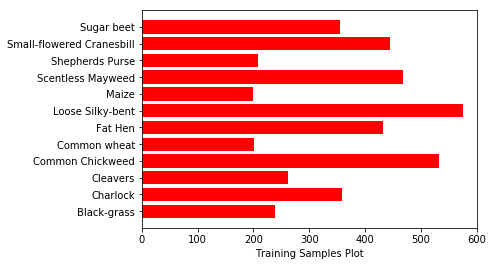

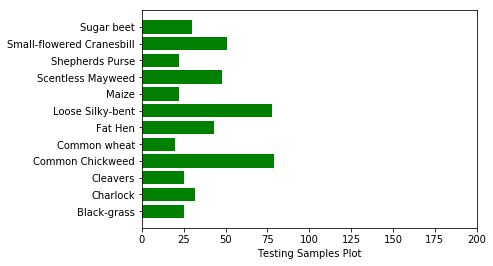

In [16]:
"""
Plot the distribution of samples across 12 classes
"""
def plot_class_distribution(targets, title, xlim, bar_color, labels):
    fig, ax      = plt.subplots()
    y_pos        = np.arange(len(labels))
    train_labels = np.sum(targets, axis=0)
    ax.barh(y_pos, train_labels, align='center', color=bar_color)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel(title)
    ax.set_xlim(0, xlim)
    plt.show()

    
plot_class_distribution(y_train_targets, 'Training Samples Plot', 600, 'red', labels)
plot_class_distribution(y_test_targets, 'Testing Samples Plot', 200, 'green', labels)

From the distribution above I notice that for the train sample Loose Silky-ben have the highest distribution
while for the test Sample Common Chickweed have more distribution

Next I will try to deal with Unbalanced Images dataset

### Data Augmentation and Oversampling for the Training Data

In [18]:
"""
Creates 2000 Augmented Training Images for each class. These are saved to the data/augmented folder.
"""
datagenerator = image.ImageDataGenerator(
        rotation_range     = 40,
        width_shift_range  = 0.2,
        height_shift_range = 0.2,
        shear_range        = 0.2,
        zoom_range         = 0.2,
        horizontal_flip    = True,
        fill_mode          = 'nearest')

def augment_and_oversample_data(x_train_tensors, y_train, labels, n = 2000):
    # empty the augmented folder if it already exists
    if os.path.isdir('data/augmented'): 
        shutil.rmtree('data/augmented')
    os.makedirs('data/augmented')
    # for each of the unique seedling ids
    for seedling_id in range(12):
        # create a folder in augmented for the seedling
        print('Augmenting training data for %s' % labels[seedling_id])
        directory_for_images = 'data/augmented/%s' % labels[seedling_id]
        os.makedirs(directory_for_images)
        imgs   = [i for i, j in enumerate(y_train) if j == seedling_id]
        random.shuffle(imgs)
        # pad imgs list to be of length n
        img    = (imgs * (n // len(imgs))) + imgs[0:n % len(imgs)]        
        # create n new tensors, iterating through all the matching tensors in x_train
        n_imgs = x_train_tensors[imgs]
        for batch in datagenerator.flow(n_imgs, batch_size=n, save_to_dir=directory_for_images, save_format='png'):
            break

augment_and_oversample_data(x_train_tensors, y_train, labels)

Augmenting training data for Black-grass
Augmenting training data for Charlock
Augmenting training data for Cleavers
Augmenting training data for Common Chickweed
Augmenting training data for Common wheat
Augmenting training data for Fat Hen
Augmenting training data for Loose Silky-bent
Augmenting training data for Maize
Augmenting training data for Scentless Mayweed
Augmenting training data for Shepherds Purse
Augmenting training data for Small-flowered Cranesbill
Augmenting training data for Sugar beet


HBox(children=(IntProgress(value=0, max=4275), HTML(value='')))

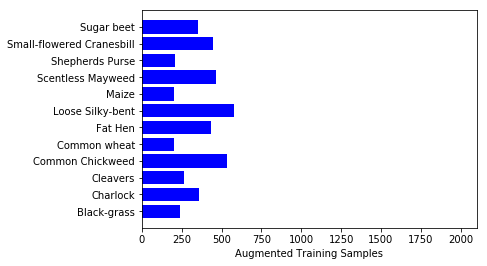

In [20]:
data_augmented      = load_files('data/augmented', load_content=False, shuffle=True, random_state=42)
x_augmented         = np.array(data_augmented['filenames'])
x_augmented_tensors = images_to_tensor(x_augmented)
y_augmented         = np.array(data_augmented['target'])

# One hot encode the targets
y_augmented_targets = np_utils.to_categorical(y_augmented, 12)

# Plot class distribution
plot_class_distribution(y_augmented_targets, 'Augmented Training Samples', 2100, 'blue', labels)



#### Define Precision and Recall
#### Create an F1 scorte function for evaluating Keras

In [24]:
def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives      = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision           = true_positives / (predicted_positives + K.epsilon())
        return precision

def recall(y_true, y_pred):
    """Recall metric.
       Only computes a batch-wise average of recall.
       Computes the recall, a metric for multi-label classification of
       how many relevant items are selected.
    """
    true_positives     = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) 
    recall             = true_positives / (possible_positives + K.epsilon())
    return recall

def F1(y_true, y_pred):
    precision_1 = precision(y_true, y_pred)
    recall_1    = recall(y_true, y_pred)
    return 2*((precision_1 * recall_1)/(precision_1 + recall_1))

#### I will First attempt to create a Convolutional Nueral Network from scratch next i will them apply transfer Learning 


## Scratch CNN Model

In [39]:
"""
Try to Compile 14-layer CNN from scratch
"""
model_cnn      = Sequential()
model_cnn.name = 'model'

# Architecture.
model_cnn.add(Conv2D(filters = 16, kernel_size = 2, strides = 1, input_shape=(224,224,3)))
model_cnn.add(MaxPooling2D(pool_size=2))
model_cnn.add(Conv2D(filters = 32, kernel_size = 2, strides = 1))
model_cnn.add(MaxPooling2D(pool_size=2))
model_cnn.add(Conv2D(filters = 64, kernel_size = 2, strides = 1))
model_cnn.add(MaxPooling2D(pool_size=2))

# Added these two layers to the hinted solution
model_cnn.add(Conv2D(filters = 128, kernel_size = 2, strides = 1))
model_cnn.add(MaxPooling2D(pool_size=2))

# Added additional layers to the hinted solution
model_cnn.add(Conv2D(filters = 256, kernel_size = 2, strides = 1))
model_cnn.add(MaxPooling2D(pool_size = 2))

# Added additional layers to the hinted solution
model_cnn.add(Conv2D(filters = 512, kernel_size = 2, strides = 1))
model_cnn.add(MaxPooling2D(pool_size=2))

model_cnn.add(GlobalAveragePooling2D())
model_cnn.add(Dense(12, activation='softmax'))
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_301 (Conv2D)          (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_302 (Conv2D)          (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_303 (Conv2D)          (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_304 (Conv2D)          (None, 26, 26, 128)       32896     
__________

#### Compile Model from scratch

In [40]:
model_cnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[F1])

## VGG19 CNN Model

In [29]:
"""
Import VGG19. Freeze the first 5 layers and retrain the remaining layers. 
Add a final layer with 12 nodes to predict the seedling species.
"""
layer_to_freeze = 10
vgg_model       = applications.VGG19(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

# freeze all the existing layers
for layer in vgg_model.layers[:layer_to_freeze]:
   layer.trainable = False

# adding custom Layers 
x = vgg_model.output
x = Flatten()(x)
predictions = Dense(12, activation='softmax')(x)

# creating the final model 
vgg_model_cnn      = Model(input = vgg_model.input, output = predictions)
vgg_model_cnn.compile(optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=[F1])
vgg_model_cnn.name = 'vgg_model_cnn'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


## Inception V3 CNN Model

In [38]:
""""
Import Inception V3. Freeze the first 50 layers and retrain the remaining layers. 
Add a final layer with 12 nodes to predict the seedling species.
"""
layer_to_freeze = 200
inception_v3    = InceptionV3(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

# freeze all the existing layers
for layer in inception_v3.layers[:last_layer_to_freeze]:
   layer.trainable = False

# adding custom Layers 
x = inception_v3.output
x = Flatten()(x)
predictions = Dense(12, activation='softmax')(x)

# creating the final model 
inception_model_cnn = Model(input = inception_v3.input, output = predictions)

inception_model_cnn.compile(optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=[F1])
inception_model_cnn.name = 'inception_model_cnn'""

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


#### Define a Train function for each of the CNN 

In [46]:
"""
Train a model. 
The best model definition and weights are saved out to an hdf5 file with the model's name.
Function Parameters:
 - model  - The compiled model to train.
 - epochs - Number of runs for the training dataset
 - x defaults to x_training_tensors, but can optionally be set to x_augmented_tensors.
 - y defaults to y_training_targets, but can optionally be set to y_augmented_targets.
 - validate_using_test_set. Two options for validation in the training loop: 
   - True: Validation uses the same test set that's also used in the evaluation step below.
   - False: 20% of the training data can be withheld for validation.
"""
def train(model, epochs = 5, x = x_train_tensors, y = y_train_targets, validate_using_test_set = True):
    checkpointer = ModelCheckpoint(filepath="data/saved_models/best.weights.from_%s.hdf5" % model.name, verbose=1, save_best_only=True)
    if validate_using_test_set:
        model.fit(x, y, validation_data=(x_test_tensors, y_test_targets), epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)
    else:
        model.fit(x, y, validation_split=0.2, shuffle=True,epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

#### Using a confusion matrix we can evaluate the perforamce of my model

In [36]:
def confusion_matrix_plot(cm, classes, title='Confusion Matrix Plot', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Next i need function that can be used to evaluate all CNN model 

In [66]:
def evaluate(model):
    model.load_weights("data/saved_models/best.weights.from_%s.hdf5" % model.name)
    y_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_test_tensors]
    y_true = np.argmax(y_test_targets, axis=1)

    f1 = f1_score(y_true, y_pred, average='micro')
    print('Test F1 Score: %.5f' % f1)
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    confusion_matrix_plot(cnf_matrix, classes=labels, title='Confusion matrix Plot')
    plt.show()

## Training, Evaluation and Prediction
Here i am going to train each model i create, evaluate and predict with them 

In [58]:
n_epochs = 20

## Train Scratch CNN model 

In [59]:
model_scratch = model_cnn

In [60]:
train(model_scratch, epochs = n_epochs, validate_using_test_set = True)

Train on 4275 samples, validate on 475 samples
Epoch 1/20
4275/4275 [==============================] - 14s 3ms/step - loss: 0.1044 - F1: 0.9719 - val_loss: 0.7848 - val_F1: 0.8265
Epoch 2/20
4275/4275 [==============================] - 14s 3ms/step - loss: 0.0914 - F1: 0.9733 - val_loss: 0.6586 - val_F1: 0.8433
Epoch 3/20
4275/4275 [==============================] - 14s 3ms/step - loss: 0.1015 - F1: 0.9704 - val_loss: 0.6934 - val_F1: 0.8307
Epoch 4/20
4275/4275 [==============================] - 14s 3ms/step - loss: 0.0792 - F1: 0.9780 - val_loss: 0.8626 - val_F1: 0.8089
Epoch 5/20
4275/4275 [==============================] - 14s 3ms/step - loss: 0.0851 - F1: 0.9773 - val_loss: 1.0147 - val_F1: 0.8229
Epoch 6/20
4275/4275 [==============================] - 14s 3ms/step - loss: 0.0739 - F1: 0.9802 - val_loss: 0.6453 - val_F1: 0.8558
Epoch 7/20
4275/4275 [==============================] - 14s 3ms/step - loss: 0.0741 - F1: 0.9822 - val_loss: 0.8587 - val_F1: 0.8402
Epoch 8/20
4275/4275 [

## Train VGG19 CNN model 

In [61]:
model_vgg19 = vgg_model_cnn

In [62]:
train(model_vgg19, epochs = n_epochs, validate_using_test_set = True)

Train on 4275 samples, validate on 475 samples
Epoch 1/20
4275/4275 [==============================] - 241s 56ms/step - loss: 2.1235 - F1: nan - val_loss: 1.6211 - val_F1: nan
Epoch 2/20
4275/4275 [==============================] - 233s 55ms/step - loss: 1.0936 - F1: nan - val_loss: 0.7992 - val_F1: 0.7112
Epoch 3/20
4275/4275 [==============================] - 233s 55ms/step - loss: 0.6187 - F1: 0.7758 - val_loss: 0.4944 - val_F1: 0.7957
Epoch 4/20
4275/4275 [==============================] - 233s 55ms/step - loss: 0.4062 - F1: 0.8649 - val_loss: 0.4150 - val_F1: 0.8512
Epoch 5/20
4275/4275 [==============================] - 233s 55ms/step - loss: 0.3148 - F1: 0.8882 - val_loss: 0.3666 - val_F1: 0.8636
Epoch 6/20
4275/4275 [==============================] - 233s 55ms/step - loss: 0.2333 - F1: 0.9211 - val_loss: 0.3290 - val_F1: 0.8817
Epoch 7/20
4275/4275 [==============================] - 233s 55ms/step - loss: 0.1860 - F1: 0.9419 - val_loss: 0.4143 - val_F1: 0.8610
Epoch 8/20
4275/4

## Train Inception V3 CNN 

In [63]:
model_inceptionV3 = inception_model_cnn

In [64]:
train(model_inceptionV3, epochs = n_epochs, validate_using_test_set = True)

Train on 4275 samples, validate on 475 samples
Epoch 1/20
4275/4275 [==============================] - 140s 33ms/step - loss: 1.5710 - F1: nan - val_loss: 0.7605 - val_F1: 0.7103
Epoch 2/20
4275/4275 [==============================] - 117s 27ms/step - loss: 0.5192 - F1: 0.8265 - val_loss: 0.4666 - val_F1: 0.8334
Epoch 3/20
4275/4275 [==============================] - 116s 27ms/step - loss: 0.2855 - F1: 0.9118 - val_loss: 0.3762 - val_F1: 0.8502
Epoch 4/20
4275/4275 [==============================] - 116s 27ms/step - loss: 0.1901 - F1: 0.9440 - val_loss: 0.3355 - val_F1: 0.8684
Epoch 5/20
4275/4275 [==============================] - 116s 27ms/step - loss: 0.1427 - F1: 0.9609 - val_loss: 0.3111 - val_F1: 0.8714
Epoch 6/20
4275/4275 [==============================] - 116s 27ms/step - loss: 0.0918 - F1: 0.9802 - val_loss: 0.3005 - val_F1: 0.8828
Epoch 7/20
4275/4275 [==============================] - 116s 27ms/step - loss: 0.0780 - F1: 0.9840 - val_loss: 0.2979 - val_F1: 0.8774
Epoch 8/20


## Evalaute Each Model

Test F1 Score: 0.85263


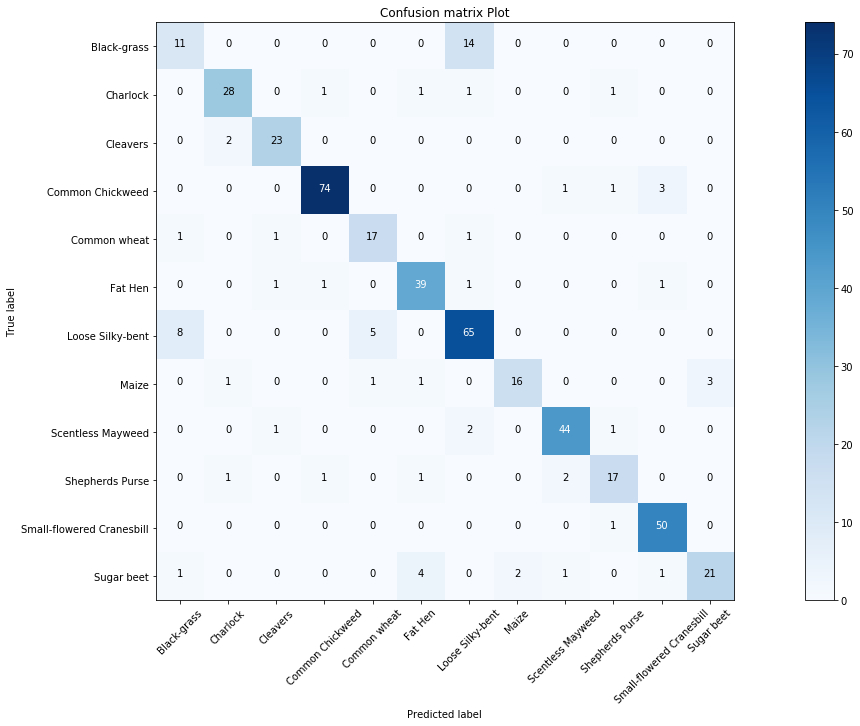

In [68]:
evaluate(model_scratch)

Test F1 Score: 0.90316


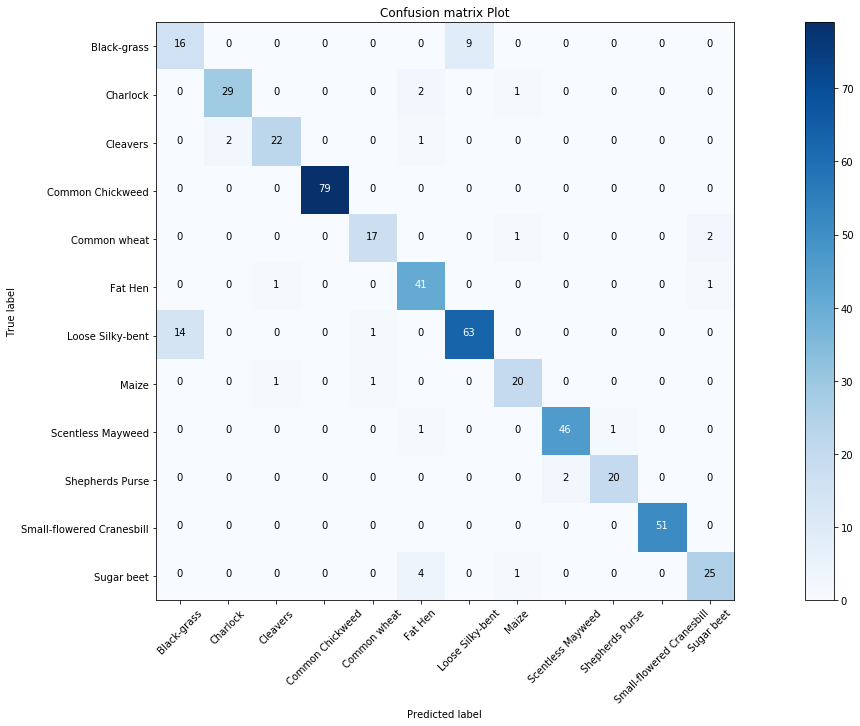

In [69]:
evaluate(model_vgg19)

Test F1 Score: 0.92421


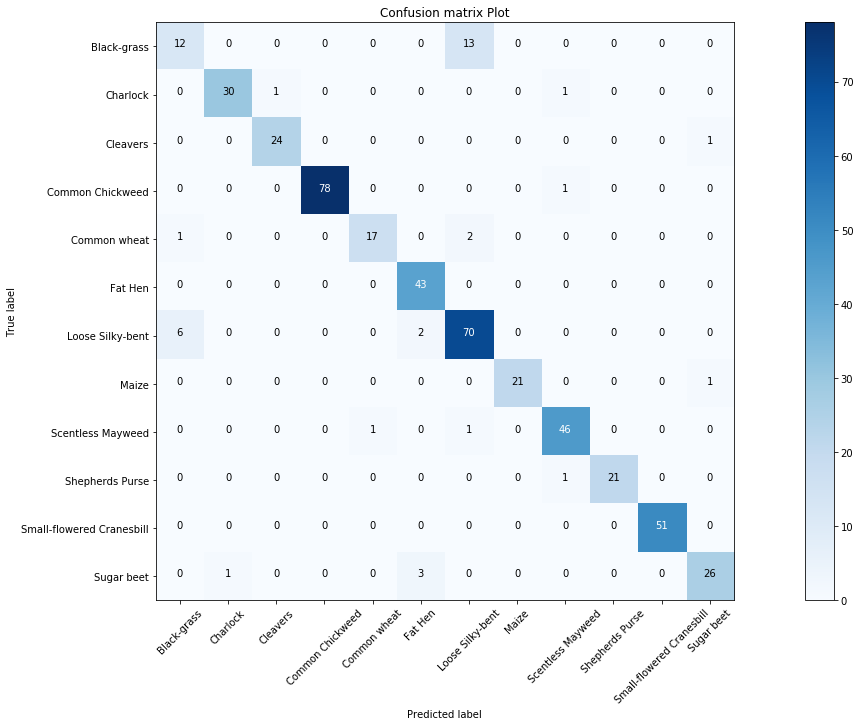

In [70]:
evaluate(model_inceptionV3)

### Predict using test data and create Kaggle submition csv

In [75]:
def predict(model):
    test_files   = glob("test/*")
    test_tensors = images_to_tensor(test_files)
    predictions  = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    file_names = [x[15:] for x in test_files]
    df         = pd.DataFrame(index=file_names, data=labels[predictions])
    df.to_csv("predictions/predictions_from_%s.csv" % model.name)

### Scratch Model Predictions

In [80]:
predict(model_scratch)

HBox(children=(IntProgress(value=0, max=794), HTML(value='')))

### VGG19 Model Predictions

In [81]:
predict(model_vgg19)

HBox(children=(IntProgress(value=0, max=794), HTML(value='')))

### Inception Model Predictions

In [82]:
predict(model_inceptionV3)

HBox(children=(IntProgress(value=0, max=794), HTML(value='')))

In [83]:
def plant_seed_classification(model, image_path):
    
    image_tensor = image_to_tensor(image_path)
    prediction   = model.predict_classes(image_tensor)
    
    print('The predicted Class of the image is {}'.format(prediction))
    INV_CLASS = {
        0: 'Black-grass',
        1: 'Charlock',
        2: 'Cleavers',
        3: 'Common Chickweed',
        4: 'Common wheat',
        5: 'Fat Hen',
        6: 'Loose Silky-bent',
        7: 'Maize',
        8: 'Scentless Mayweed',
        9: 'Shepherds Purse',
        10: 'Small-flowered Cranesbill',
        11: 'Sugar beet'
     }
    print('The class of the specie is',[INV_CLASS[p] for p in prediction])

In [84]:
plant_seed_classification(model_scratch, "train/Maize/006196e1c.png")

1/1 [==============================] - 0s 5ms/step
The predicted Class of the image is [7]
The class of the specie is ['Maize']


In [85]:
plant_seed_classification(model_scratch, "train/Maize/69f06fcbc.png") 

1/1 [==============================] - 0s 6ms/step
The predicted Class of the image is [7]
The class of the specie is ['Maize']


In [87]:
plant_seed_classification(model_scratch, "train/Cleavers/58be08e22.png") 

1/1 [==============================] - 0s 5ms/step
The predicted Class of the image is [2]
The class of the specie is ['Cleavers']
